In [309]:
import warnings
warnings.filterwarnings("ignore")                     #Ignoring unnecessory warnings
import pandas as pd
import numpy as np
from datetime import datetime
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

##
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
%matplotlib inline


# Standard plotly imports
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

##
from fancyimpute import IterativeImputer as MICE
mice = MICE(n_nearest_features=30)

##

import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import wordninja

#
# import tensorflow_hub as hub
# embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/2")

#
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# EDA

In [2]:
listings = pd.read_csv('listings.csv', delimiter=';')
test_listings = pd.read_csv('listings_test_send.csv',delimiter=';')

In [3]:
train_df = listings.drop(['Unnamed: 0','ID'],1)
test_df = test_listings.drop(['Unnamed: 0','GUID'],1)

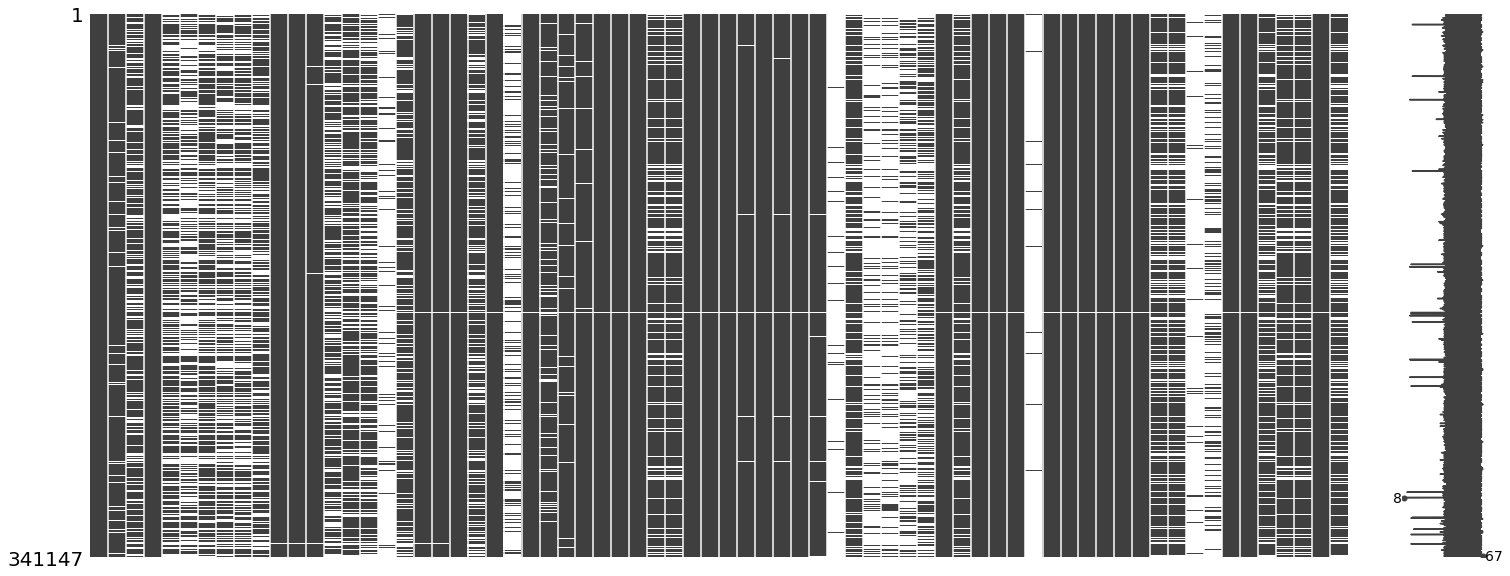

In [4]:


missingdata_df = train_df.columns[train_df.isnull().any()].tolist()
msno.matrix(train_df[missingdata_df])

In [5]:
## Null Counting Fucntion
def null_values(df):
    
    sum_null = df.isnull().sum()
    total = df.isnull().count()
    percent_nullvalues = 100* sum_null / total 
    df_null = pd.DataFrame()
    df_null['Total'] = total
    df_null['Null_Count'] = sum_null
    df_null['Percent'] = round(percent_nullvalues,2)
    df_null = df_null.sort_values(by='Null_Count',ascending = False)
    df_null = df_null[df_null.Null_Count > 0]
    
    return(df_null)

In [97]:
train_df.head()

,Name,Summary,Space,Description,Experiences_Offered,Neighborhood_Overview,Transit,Access,Interaction,House_Rules,Host_Name,Host_Since,Host_Location,Host_About,Host_Response_Time,Host_Response_Rate,Host_Neighbourhood,Host_Listings_Count,Host_Total_Listings_Count,Street,Neighbourhood,Neighbourhood_Cleansed,City,State,Zipcode,Market,Smart_Location,Country_Code,Country,Latitude,Longitude,Property_Type,Room_Type,Accommodates,Bathrooms,Bedrooms,Beds,Bed_Type,Amenities,Price,Cleaning_Fee,Guests_Included,Extra_People,Minimum_Nights,Maximum_Nights,Calendar_Updated,Availability_30,Availability_60,Availability_90,Availability_365,Calendar_last_Scraped,Number_of_Reviews,First_Review,Last_Review,Cancellation_Policy,Calculated_host_listings_count,Reviews_per_Month,Geolocation,Features,Listing_Type,Rating
0,Private room in sunny three bedroom,This apartment in the West Rogers Park (or Wes...,Hi there traveler. Thanks for considering sta...,This apartment in the West Rogers Park (or Wes...,none,I love that my neighborhood is so quiet and lo...,Parking around here is very easy. You might wi...,"You will have your private room, and you are w...",I do live in the master bedroom in this apartm...,Not much to say outside of common sense. Bring...,Steve And Peter,2011-08-15,"Chicago, Illinois, United States","When I have the opportunity to travel, I love ...",within an hour,99.0,Avondale,4.0,4.0,"Avondale, Chicago, IL 60659, United States",Avondale,West Ridge,Chicago,IL,60659,Chicago,"Chicago, IL",US,United States,41.994170,-87.692030,Apartment,Private room,2.0,1.0,1.0,1.0,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",50.0,NaN,1.0,9.0,2.0,7,6 days ago,23.0,53.0,83.0,126.0,2017-05-10,93.0,2011-08-27,2016-09-18,moderate,4.0,1.34,"41.9941700301, -87.6920295649","Host Has Profile Pic,Host Identity Verified,Re...",Good,67259.201267
1,Lovely & cute apartment,Lovely apartment for a couple or a single pers...,Interior desig in accordance with the Scandina...,Lovely apartment for a couple or a single pers...,none,Quite and peaceful neighborhood in the Frederi...,Close to bus and the metro stations 'Frederiks...,"Fully equipped kitchen, 5 shelfs for your stuf...",I will not be living in the apartment while yo...,I expect you to leave my apartment in the exac...,Pernille,2012-02-10,"Copenhagen, Capital Region of Denmark, Denmark",I am a happy young woman living in Copenhagen ...,NaN,NaN,NaN,1.0,1.0,"Frederiksberg, 2000, Denmark",NaN,Frederiksberg,Frederiksberg,NaN,2000,Copenhagen,"Frederiksberg, Denmark",DK,Denmark,55.691395,12.535288,Apartment,Entire home/apt,2.0,1.0,1.0,1.0,Real Bed,"Internet,Kitchen,Pets live on this property,Do...",371.0,112,1.0,0.0,1.0,1125,5 months ago,0.0,0.0,0.0,165.0,2017-06-15,1.0,2014-10-31,2014-10-31,flexible,1.0,0.03,"55.6913945558, 12.5352884346",Host Has Profile Pic,Good,58503.191267
2,Unique house with a beautiful garden,Beautiful design cosy family house with a nice...,"Beautiful garden, two level house (105 m2) nea...",Beautiful design cosy family house with a nice...,none,Nice multicultural neighbourhood with plenty o...,Tram and bus stops in a 5 minutes walk distanc...,House and garden,"Limited, only via telephone if necessary.",Smoke free house :) Since our house is designe...,Mina,2012-10-23,"Amsterdam, North Holland, The Netherlands",NaN,within a day,100.0,NaN,1.0,1.0,"Amsterdam, Noord-Holland 1057, Netherlands",NaN,De Baarsjes - Oud-West,Amsterdam,Noord-Holland,1057,Amsterdam,"Amsterdam, Netherlands",NL,Netherlands,52.368966,4.849840,Apartment,Entire home/apt,4.0,1.0,2.0,4.0,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Heating,...",145.0,80,1.0,0.0,3.0,1125,3 days ago,0.0,0.0,7.0,7.0,2017-04-02,2.0,2016-09-07,2016-10-02,strict,1.0,0.29,"52.3689656398, 4.84983993143","Host Has Profile Pic,Is Location Exact",Good,58480.587448
3,Résidence du 14 Rue des Sablons;,"50 m2, un grand lit et un canapé lit deux plac...",NaN,"50 m2, un grand lit et un canapé lit deux plac...",none,NaN,NaN,NaN,NaN,NaN,Lucile,2015-

In [118]:
train_df['Host_Since'].value_counts()

2016-07-18    1156
2015-05-21     736
2012-09-20     635
2015-03-30     434
2015-07-29     409
              ... 
2008-10-01       1
2008-07-22       1
2009-07-21       1
2008-09-23       1
2009-07-08       1
Name: Host_Since, Length: 3097, dtype: int64

In [6]:
null_val_df = null_values(train_df)
columns_to_drop = null_val_df[null_val_df.Percent> 50].index.to_list()

In [7]:
for col in columns_to_drop:
    train_df.drop([col],1,inplace=True)

In [8]:
def create_data_subsets(head_df):
    minority_df = head_df[head_df.Listing_Type=='Bad']
    majority_df = head_df[head_df.Listing_Type=='Good']
    
    # creating 5 sub_heads from majority_df
    total_len = len(majority_df)
    sub_split_len = total_len//5
    majority_df.sample(frac=1)
    majority_df1 = majority_df[:sub_split_len]
    majority_df2 = majority_df[sub_split_len:sub_split_len*2]
    majority_df3 = majority_df[sub_split_len*2:sub_split_len*3]
    majority_df4 = majority_df[sub_split_len*3:sub_split_len*4]
    majority_df5 = majority_df[sub_split_len*4:]
    print('Total dataset size: ',total_len)
    print('Subset shapes: ',(len(majority_df1),len(majority_df2),len(majority_df3),len(majority_df4), len(majority_df5)))
    
    # combine and shuffle
    df1 = majority_df1.append(minority_df)
    df2 = majority_df2.append(minority_df)
    df3 = majority_df3.append(minority_df)
    df4 = majority_df4.append(minority_df)
    df5 = majority_df5.append(minority_df)
    
    return df1.sample(frac=1), df2.sample(frac=1), df3.sample(frac=1), df4.sample(frac=1), df5.sample(frac=1)
    
df1, df2, df3, df4, df5 = create_data_subsets(train_df)

Total dataset size:  309045
Subset shapes:  (61809, 61809, 61809, 61809, 61809)


In [9]:
df1.Listing_Type.value_counts()

Good    61809
Bad     31144
Name: Listing_Type, dtype: int64

In [10]:
df1.Listing_Type.value_counts(normalize=True).iplot(kind='bar')

# Missing value Details

In [11]:
null_value_df1 = null_values(df1)

In [12]:
null_value_df1

,Total,Null_Count,Percent
Interaction,92953,49913,53.70
Cleaning_Fee,92953,49276,53.01
Access,92953,47280,50.86
Host_About,92953,45946,49.43
Neighborhood_Overview,92953,43562,46.86
House_Rules,92953,42241,45.44
Transit,92953,41045,44.16
Host_Response_Rate,92953,40367,43.43
Rating,92953,38018,40.90
First_Review,92953,36007,38.74


In [58]:
df1.corr('spearman').iplot(kind='heatmap')

In [13]:
null_values(df1).iplot(y=['Null_Count'],kind='line')

In [14]:
null_values(df1).iplot(y=['Percent'],kind='line')

# Numerical Data Analysis

In [158]:
numerical_cols = [
    'Host_Since', 'Host_Listings_Count', 'Accommodates', 'Cleaning_Fee',
    'Guests_Included', 'Maximum_Nights', 'Calendar_last_Scraped',
    'First_Review', 'Last_Review', 'Geolocation'
]

In [176]:
all_numerical_columns = df1.select_dtypes(exclude=['object']).columns.to_list() + numerical_cols

In [212]:
numerical_df = df1[all_numerical_columns]

In [213]:
numerical_df.Host_Since.ffill(axis=0, inplace=True)
numerical_df['Host_Since'] = pd.to_datetime(numerical_df['Host_Since'],
                                            format='%Y-%m-%d',
                                            errors='coerce')

numerical_df.Calendar_last_Scraped.ffill(axis=0, inplace=True)
numerical_df['Calendar_last_Scraped'] = pd.to_datetime(
    numerical_df['Calendar_last_Scraped'], format='%Y-%m-%d', errors='coerce')

numerical_df.First_Review.ffill(axis=0, inplace=True)
numerical_df['First_Review'] = pd.to_datetime(numerical_df['First_Review'],
                                              format='%Y-%m-%d',
                                              errors='coerce')

numerical_df.Last_Review.ffill(axis=0, inplace=True)
numerical_df['Last_Review'] = pd.to_datetime(numerical_df['Last_Review'],
                                             format='%Y-%m-%d',
                                             errors='coerce')

In [214]:
numerical_df['Host_Since_dayofyear'] = numerical_df.Host_Since.dt.dayofyear
numerical_df['Host_Since_weekday'] = numerical_df.Host_Since.dt.weekday
numerical_df['Host_Since_week'] = numerical_df.Host_Since.dt.week
numerical_df['Host_Since_quarter'] = numerical_df.Host_Since.dt.quarter

numerical_df[
    'Calendar_last_Scraped_dayofyear'] = numerical_df.Calendar_last_Scraped.dt.dayofyear
numerical_df[
    'Calendar_last_Scraped_weekday'] = numerical_df.Calendar_last_Scraped.dt.weekday
numerical_df[
    'Calendar_last_Scraped_week'] = numerical_df.Calendar_last_Scraped.dt.week
numerical_df[
    'Calendar_last_Scraped_quarter'] = numerical_df.Calendar_last_Scraped.dt.quarter

numerical_df['First_Review_dayofyear'] = numerical_df.First_Review.dt.dayofyear
numerical_df[
    'First_Review_Scraped_weekday'] = numerical_df.First_Review.dt.weekday
numerical_df['First_Review_Scraped_week'] = numerical_df.First_Review.dt.week
numerical_df['First_Review_quarter'] = numerical_df.First_Review.dt.quarter

numerical_df['Last_Review_dayofyear'] = numerical_df.Last_Review.dt.dayofyear
numerical_df['Last_Review_weekday'] = numerical_df.Last_Review.dt.weekday
numerical_df['Last_Review_week'] = numerical_df.Last_Review.dt.week
numerical_df['Last_Review_quarter'] = numerical_df.Last_Review.dt.quarter

In [215]:
numerical_df.drop([
    'Host_Since', 'Calendar_last_Scraped', 'First_Review', 'Last_Review',
    'Geolocation'
],
    1,
    inplace=True)

In [216]:
for column in numerical_df.columns:
    numerical_df[column] = pd.to_numeric(numerical_df[column],errors='coerce')

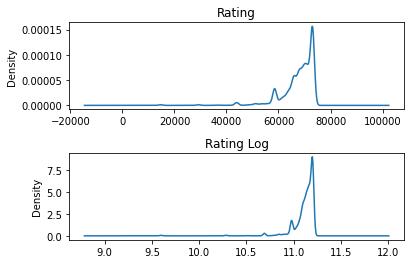

In [217]:
# By log tranformation, right skewed distribution can be a normal form.
plt.subplot2grid((2, 1), (0, 0))
numerical_df.Rating.plot(kind='kde')
plt.title('Rating')

plt.subplot2grid((2, 1), (1, 0))
numerical_df['Rating_log'] = np.log(numerical_df.Rating)
numerical_df['Rating_log'].plot(kind='kde')
plt.title('Rating Log')

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [218]:
numerical_df.drop('Rating',1,inplace=True)

In [219]:
def lat_long_feature_standarization(lat, long):
    x = cos(lat) * cos(lon)
    y = cos(lat) * sin(lon), 
    z = sin(lat) 

In [220]:
numerical_df['coord_x'] = np.cos(numerical_df['Latitude']) * np.cos(
    numerical_df['Longitude'])
numerical_df['coord_y'] = np.cos(numerical_df['Latitude']) * np.sin(
    numerical_df['Longitude'])
numerical_df['coord_z'] = np.sin(numerical_df['Latitude'])

In [221]:
numerical_df.drop(['Latitude','Longitude'],1,inplace=True)

In [222]:
numerical_df.head()

,Host_Response_Rate,Host_Total_Listings_Count,Bathrooms,Bedrooms,Beds,Price,Extra_People,Minimum_Nights,Availability_30,Availability_60,Availability_90,Availability_365,Number_of_Reviews,Calculated_host_listings_count,Reviews_per_Month,Host_Listings_Count,Accommodates,Cleaning_Fee,Guests_Included,Maximum_Nights,Host_Since_dayofyear,Host_Since_weekday,Host_Since_week,Host_Since_quarter,Calendar_last_Scraped_dayofyear,Calendar_last_Scraped_weekday,Calendar_last_Scraped_week,Calendar_last_Scraped_quarter,First_Review_dayofyear,First_Review_Scraped_weekday,First_Review_Scraped_week,First_Review_quarter,Last_Review_dayofyear,Last_Review_weekday,Last_Review_week,Last_Review_quarter,Rating_log,coord_x,coord_y,coord_z
55060,99.0,34.0,1.0,1.0,2.0,35.0,15.0,3.0,2.0,17.0,47.0,322.0,47.0,30.0,1.38,34.0,3.0,35.0,2.0,1125.0,57,2,9,1,74,2,11,1,146,0,22,2,296,5,42,4,10.989260,0.259873,-0.144587,0.954757
250937,NaN,1.0,2.0,4.0,4.0,NaN,NaN,4.0,0.0,0.0,3.0,3.0,0.0,1.0,NaN,1.0,6.0,NaN,1.0,60.0,92,4,13,2,188,2,27,3,146,0,22,2,296,5,42,4,NaN,NaN,NaN,NaN
58683,96.0,93.0,1.0,1.0,2.0,119.0,15.0,1.0,6.0,22.0,40.0,308.0,13.0,48.0,0.25,93.0,4.0,25.0,2.0,330.0,183,6,26,3,129,1,19,2,2,2,1,1,254,4,37,3,11.060643,-0.294554,-0.780702,0.551129
20937,100.0,1.0,1.0,1.0,4.0,260.0,0.0,6.0,23.0,53.0,83.0,358.0,0.0,1.0,NaN,1.0,5.0,80.0,1.0,1125.0,221,0,32,3,96,3,14,2,2,2,1,1,254,4,37,3,NaN,-0.110573,0.111011,-0.987649
62956,100.0,1.0,1.0,1.0,1.0,85.0,0.0,6.0,0.0,0.0,13.0,13.0,2.0,1.0,1.05,1.0,3.0,30.0,1.0,1125.0,320,0,47,4,64,6,9,1,8,6,1,1,32,2,5,1,10.976428,0.322521,0.006508,0.946540


In [223]:
null_values(numerical_df)

,Total,Null_Count,Percent
Cleaning_Fee,92953,49276,53.01
Host_Response_Rate,92953,40367,43.43
Rating_log,92953,38018,40.90
Reviews_per_Month,92953,36007,38.74
Price,92953,17884,19.24
Extra_People,92953,16490,17.74
coord_y,92953,16482,17.73
coord_x,92953,16482,17.73
coord_z,92953,16482,17.73
Host_Total_Listings_Count,92953,365,0.39


In [224]:
all_numerical_df = pd.DataFrame(data=mice.fit_transform(numerical_df),
                                columns=numerical_df.columns)

In [225]:
all_numerical_df.head()

,Host_Response_Rate,Host_Total_Listings_Count,Bathrooms,Bedrooms,Beds,Price,Extra_People,Minimum_Nights,Availability_30,Availability_60,Availability_90,Availability_365,Number_of_Reviews,Calculated_host_listings_count,Reviews_per_Month,Host_Listings_Count,Accommodates,Cleaning_Fee,Guests_Included,Maximum_Nights,Host_Since_dayofyear,Host_Since_weekday,Host_Since_week,Host_Since_quarter,Calendar_last_Scraped_dayofyear,Calendar_last_Scraped_weekday,Calendar_last_Scraped_week,Calendar_last_Scraped_quarter,First_Review_dayofyear,First_Review_Scraped_weekday,First_Review_Scraped_week,First_Review_quarter,Last_Review_dayofyear,Last_Review_weekday,Last_Review_week,Last_Review_quarter,Rating_log,coord_x,coord_y,coord_z
0,99.000000,34.0,1.0,1.0,2.0,35.000000,15.000000,3.0,2.0,17.0,47.0,322.0,47.0,30.0,1.380000,34.0,3.0,35.00000,2.0,1125.0,57.0,2.0,9.0,1.0,74.0,2.0,11.0,1.0,146.0,0.0,22.0,2.0,296.0,5.0,42.0,4.0,10.989260,0.259873,-0.144587,0.954757
1,92.460386,1.0,2.0,4.0,4.0,238.876377,-1.933247,4.0,0.0,0.0,3.0,3.0,0.0,1.0,0.357806,1.0,6.0,96.82545,1.0,60.0,92.0,4.0,13.0,2.0,188.0,2.0,27.0,3.0,146.0,0.0,22.0,2.0,296.0,5.0,42.0,4.0,11.137894,-0.325291,-0.216855,-0.112163
2,96.000000,93.0,1.0,1.0,2.0,119.000000,15.000000,1.0,6.0,22.0,40.0,308.0,13.0,48.0,0.250000,93.0,4.0,25.00000,2.0,330.0,183.0,6.0,26.0,3.0,129.0,1.0,19.0,2.0,2.0,2.0,1.0,1.0,254.0,4.0,37.0,3.0,11.060643,-0.294554,-0.780702,0.551129
3,100.000000,1.0,1.0,1.0,4.0,260.000000,0.000000,6.0,23.0,53.0,83.0,358.0,0.0,1.0,0.654549,1.0,5.0,80.00000,1.0,1125.0,221.0,0.0,32.0,3.0,96.0,3.0,14.0,2.0,2.0,2.0,1.0,1.0,254.0,4.0,37.0,3.0,11.091178,-0.110573,0.111011,-0.987649
4,100.000000,1.0,1.0,1.0,1.0,85.000000,0.000000,6.0,0.0,0.0,13.0,13.0,2.0,1.0,1.050000,1.0,3.0,30.00000,1.0,1125.0,320.0,0.0,47.0,4.0,64.0,6.0,9.0,1.0,8.0,6.0,1.0,1.0,32.0,2.0,5.0,1.0,10.976428,0.322521,0.006508,0.946540


In [226]:
null_values(all_numerical_df)

,Total,Null_Count,Percent


In [227]:
all_object_columns =list( set(train_df.columns.to_list()) - set(all_numerical_columns) )

In [232]:
categorical_df = df1[all_object_columns]

In [233]:
categorical_df.head()

,Features,Smart_Location,Amenities,Listing_Type,State,Host_Name,Host_Neighbourhood,Host_Response_Time,Host_Location,Cancellation_Policy,Host_About,City,Space,Calendar_Updated,Zipcode,Name,Country,Neighbourhood,Street,House_Rules,Experiences_Offered,Interaction,Summary,Property_Type,Access,Transit,Room_Type,Description,Neighbourhood_Cleansed,Market,Bed_Type,Country_Code,Neighborhood_Overview
55060,"Host Has Profile Pic,Host Identity Verified,Is...","Palma de Mallorca, Spain","TV,Wireless Internet,Kitchen,Elevator in build...",Good,Islas Baleares,Pepe,NaN,within an hour,"Palma de Mallorca, Balearic Islands, Spain",strict,Hello I am from Majorca and I live in Palma de...,Palma de Mallorca,As you can see on the photos kitchen is equipp...,4 weeks ago,07014,NICE apt in center of Palma for 2-3,Spain,NaN,"Palma de Mallorca, Islas Baleares 07014, Spain",Late checkin after 22:00 has an aditional cost...,none,Late checkin after 23:00 has an aditional cost...,"This apartment has a excellent location, new f...",Apartment,NaN,TRANSPORT- bus stop is on Marques de la Senia ...,Entire home/apt,"This apartment has a excellent location, new f...",Palma de Mallorca,Mallorca Island,Real Bed,ES,CENTRAL means that 1) OLD TOWN (area where the...
250937,NaN,"San Diego, CA","{TV,Internet,""Wireless Internet"",""Air Conditio...",Bad,CA,Kelly,NaN,within an hour,US,strict,NaN,San Diego,NaN,today,92109,Bayside Beauty Steps to the Beach,United States,NaN,"Buena Vista Street, San Diego, CA 92109, Unite...","No Disturbing the neighbors, Strip sheets and ...",none,NaN,Quiet residence less than a half a block to Sa...,House,NaN,NaN,Entire home/apt,Quiet residence less than a half a block to Sa...,Mission Bay,San Diego,Real Bed,US,NaN
58683,"Host Has Profile Pic,Host Identity Verified,Is...","City of Brussels, Belgium","Cable TV,Wireless Internet,Kitchen,Heating,Smo...",Good,Brussels,Tarik,Grand Place,within a few hours,"Brussels, Bruxelles, Belgium",moderate,Our aim is to provide to our guest the keys of...,City of Brussels,Your Smartflats provides you with: - 1 Bedroom...,today,1000,Smartflats Brusselian 101 - 1Bedroom - City Ce...,Belgium,Grand Place,"Grand Place, City of Brussels, Brussels 1000, ...",Please treat this place as your home. We kindl...,none,We are available by ph(PHONE NUMBER HIDDEN)) a...,Stylish and cosy one bedroom flat ideally loca...,Apartment,The flat is all yours!,The closest metro station is De Brouckère (dir...,Entire home/apt,Stylish and cosy one bedroom flat ideally loca...,Bruxelles,Brussels,Real Bed,BE,"Our flat is located right in the city center, ..."
20937,"Host Has Profile Pic,Is Location Exact","Paris, France","TV,Wireless Internet,Kitchen,Heating,Washer,Dr...",Good,Île-de-France,Pierre,Saint-Paul - Ile Saint-Louis,within an hour,"Paris, Île-de-France, France",flexible,NaN,Paris,Artist workshop transformed in a splendid Loft...,8 months ago,75004,Design Loft on Ile Saint Louis,France,Saint-Paul - Ile Saint-Louis,"Saint-Paul - Ile Saint-Louis, Paris, Île-de-Fr...",NaN,none,My office is close so you can rely on me if yo...,"Mon logement est parfait pour les couples, les...",Apartment,NaN,"Metro stations all around, as well as velib an...",Entire home/apt,"Mon logement est parfait pour les couples, les...",Hôtel-de-Ville,Paris,Real Bed,FR,Ile Saint Louis is the place to be in Paris be...
62956,"Host Has Profile Pic,Host Identity Verified,Is...","London, United Kingdom","TV,Wireless Internet,Kitchen,Elevator in build...",Good,England,Ola,LB of Newham,within a few hours,GB,flexible,NaN,London,NaN,2 weeks ago,E16,Spacious 1 bedroom apartment at ExCel Centre,United Kingdom,LB of Newham,"Western Gateway, London, England E16, United K...",NaN,none,NaN,"My place is close to ExCeL London, Emirates Ai...",Apartment,NaN,NaN,Entire home/apt,"My place is close to ExCeL London, Emirates Ai...",Newham,London,Real Bed,GB,NaN


In [270]:
import contractions
import wordninja
import re
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


def text_cleaning(data, column_name):
    # function to remove non-ascii characters
    def _removeNonAscii(s): return "".join(i.lower()
                                           for i in s if ord(i) < 128)
    # remove non-ascii characters
    data[column_name] = data[column_name].map(
        lambda x: _removeNonAscii(str(x)))
    # remove url
    data[column_name] = data[column_name].apply(
        lambda x: re.sub(r'http\S+', '', x))
    data[column_name] = data[column_name].apply(
        lambda x: [contractions.fix(word) for word in x.split()])
    # remove special characters, numbers, punctuations
    data[column_name] = data[column_name].apply(
        lambda x: [y for y in x if y not in stop_words])
    data[column_name] = data[column_name].apply(lambda x: ' '.join(x))
    data[column_name] = data[column_name].str.replace("[^a-zA-Z0-9]", " ")
    # wordninja splits words like "dayoftheyear" to  "day of the year"
    data[column_name] = data[column_name].apply(
        lambda x: [wordninja.split(word) for word in x.split()])
    data[column_name] = data[column_name].apply(
        lambda x: [item for sublist in x for item in sublist])
    data[column_name] = data[column_name].apply(lambda x: ' '.join(x))
    return data[column_name]

In [294]:
from tqdm import tqdm
for column in tqdm(categorical_df.columns):
    categorical_df[column]=text_cleaning(categorical_df,column)

100%|██████████| 33/33 [20:34<00:00, 37.40s/it] 


In [345]:
categorical_df.head()

,Features,Smart_Location,Amenities,Listing_Type,State,Host_Name,Host_Neighbourhood,Host_Response_Time,Host_Location,Cancellation_Policy,Host_About,City,Space,Calendar_Updated,Zipcode,Name,Country,Neighbourhood,Street,House_Rules,Experiences_Offered,Interaction,Summary,Property_Type,Access,Transit,Room_Type,Description,Neighbourhood_Cleansed,Market,Bed_Type,Country_Code,Neighborhood_Overview,Categorical_Description
55060,host profile pic host identity verified locati...,palma de mallorca spain,tv wireless internet kitchen elevator building...,good,islas bale are s,pepe,nan,within hour,palma de mallorca balearic islands spain,strict,hello majorca live palma de mallorca love trav...,palma de mallorca,see photos kitchen equipped available oven mic...,4 weeks ago,07014,nice apt center palma 2 3,spain,nan,palma de mallorca islas bale are s 07014 spain,late check in 22 00 adit ional cost 15 cash ch...,none,late check in 23 00 adit ional cost 10,apartment excellent location new furniture bou...,apartment,nan,transport bus stop marques de la s eni a stree...,entire home apt,apartment excellent location new furniture bou...,palma de mallorca,mallorca island,real bed,es,central means 1 old town area cathedral paseo ...,tv wireless internet kitchen elevator building...
250937,nan,san diego ca,tv internet wireless internet air conditioning...,bad,ca,kelly,nan,within hour,us,strict,nan,san diego,nan,today,92109,bayside beauty steps beach,united states,nan,buena vista street san diego ca 92109 united s...,disturbing neighbors strip sheets start wash p...,none,nan,quiet residence less half block sail bay four ...,house,nan,nan,entire home apt,quiet residence less half block sail bay four ...,mission bay,san diego,real bed,us,nan,tv internet wireless internet air conditioning...
58683,host profile pic host identity verified locati...,city brussels belgium,cable tv wireless internet kitchen heating smo...,good,brussels,t arik,grand place,within hours,brussels bruxelles belgium,moderate,aim provide guest keys city smart flats could ...,city brussels,smart flats provides with 1 bedroom large doub...,today,1000,smart flats b russel ian 101 1 bedroom city ce...,belgium,grand place,grand place city brussels brussels 1000 belgium,please treat place home kindly ask bring pets ...,none,available ph phone number hidden email every d...,stylish cosy one bedroom flat ideally located ...,apartment,flat yours,closest metro station de brou ck re direct con...,entire home apt,stylish cosy one bedroom flat ideally located ...,bruxelles,brussels,real bed,,flat located right city center 5 minutes walk ...,cable tv wireless internet kitchen heating smo...
20937,host profile pic location exact,paris france,tv wireless internet kitchen heating was her d...,good,le de france,pierre,saint paul ile saint louis,within hour,paris le de france france,flexible,nan,paris,artist workshop transformed splendid loft 100 ...,8 months ago,75004,design loft ile saint louis,france,saint paul ile saint louis,saint paul ile saint louis paris le de france ...,nan,none,office close rely need help,mon loge ment est parfait pour les couples les...,apartment,nan,metro stations around well veli b auto lib,entire home apt,mon loge ment est parfait pour les couples les...,h tel de ville,paris,real bed,fr,ile saint louis place paris charming close man...,tv wireless internet kitchen heating was her d...
62956,host profile pic host identity verified locati...,london united kingdom,tv wireless internet kitchen elevator building...,good,england,ola,lb newham,within hours,gb,flexible,nan,london,nan,2 weeks ago,e 16,spacious 1 bedroom apartment excel centre,united kingdom,lb newham,western gateway london england e 16 united kin...,nan,none,nan,place close excel london emirates air line cab...,apartment,nan,nan,entire home apt,place close excel london emirates air line cab...,newham,london,real bed,gb,nan,tv wireless internet kitchen elevator building...


In [342]:
categorical_df['Categorical_Description'] = categorical_df['Amenities']+categorical_df['Summary']+categorical_df['Transit']

In [343]:
categorical_df['Categorical_Description']

55060     tv wireless internet kitchen elevator building...
250937    tv internet wireless internet air conditioning...
58683     cable tv wireless internet kitchen heating smo...
20937     tv wireless internet kitchen heating was her d...
62956     tv wireless internet kitchen elevator building...
                                ...                        
151486    tv cable tv internet wireless internet kitchen...
19690     tv wireless internet kitchen heating essential...
51725     tv wireless internet kitchen heating was her d...
54565     wireless internet kitchen elevator building bu...
224573    tv internet wireless internet air conditioning...
Name: Categorical_Description, Length: 92953, dtype: object

In [355]:
label_encoder.fit_transform(categorical_df.Property_Type)

array([ 1, 20,  1, ...,  1,  1,  1])

In [356]:
pd.get_dummies(categorical_df.Property_Type)

,,apartment,bed breakfast,boat,boutique hotel,bungalow,cabin,camper rv,car,casa particular,castle,cave,chalet,condominium,dorm,earth house,entire floor,guest suite,guesthouse,hostel,house,hut,igloo,in law,island,lighthouse,loft,nan,nature lodge,parking space,pension korea,serviced apartment,tent,timeshare,tipi,townhouse,treehouse,vacation home,villa,yu rt
55060,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
250937,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
58683,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20937,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
62956,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151486,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19690,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51725,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
54565,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [357]:
import tensorflow_hub as hub
embed = hub.load("/Users/subir/tf-models/use-model/4")


AttributeError: module 'tensorflow_hub.tf_v1' has no attribute 'estimator'

In [363]:
df=categorical_df.join(numerical_df)

In [365]:
df.shape

(92953, 74)

In [366]:
categorical_df.shape

(92953, 34)

In [367]:
numerical_df.shape

(92953, 40)

In [369]:
from sklearn import datasets
from sklearn import svm
clf = svm.SVC()

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

embed = hub.load("/Users/subir/tf-models/use-model/4")

tf.logging.set_verbosity(tf.logging.ERROR)
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(embed(["messages"]))

In [5]:
message_embeddings.shape

(1, 512)

In [6]:
tf.__version__

'1.15.2'